# EPUG: Particle Modeling -- An In-Depth Numpy Use-Case Example

*by Jonas Hartmann on 12.05.2020*\
*with thanks to Gregor Mönke for useful inputs during the live session*

#### Purpose

This is a live coding example of using numpy for numerical modeling. It is intended as a means of illustrating various concepts and details related to numpy-based code and to numerical modeling in general. The model and code both have their flaws and should not be reused in scientific projects without extensive testing and validation.


#### Model

Particle models are a broadly useful class of models that can be utilized to simulate a wide range of phenomena across different fields and scales. Their core conceit is that the relevant entities of the system of interest can be represented as particles with various properties, most notably their location in space. Rules/equations (also called time step functions or propagators) are then written to describe how these properties change over the course of small discrete time steps. The model is then simulated by iteratively updating the particle properties based on said rules.

Here, we implement a very basic 2D particle model that mimics the behavior of an ideal gas. Particles move along ballistic trajectories and undergo elastic collisions when they intersect - conservation of momentum applies. Variations of this basic model can be used to simulate people in a society, cells in a tissue, birds in a flock and many other systems. For systems with a very large number of particles, simulation may become impractical and often unnecessary; as the number of particles approaches the 'thermodynamic limit', it may become possible to use mathematical abstractions to describe the system in an accurate and elegant fashion, as is for instance the case with diffusion of particles in aqueous solution.

It is important to remember that "all models are wrong but some models are *very* wrong". Care must always be taken to validate the assumptions underlying a model, to extensively test the computational implementation, and to check at least some of the key predictions experimentally.

### Basic Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Defining parameters and initial state

In [2]:
# Model parameters
n_particles = 400
n_steps     = 200
delta_t     = 0.1

# Note: The smaller delta_t, the less "real time" passes in each time step.
#       Thus, the simulation will need to run for more steps to simulate 
#       the same amount of "real time". Importantly, smaller time steps 
#       lead to greater accuracy in numerical simulations, as they reduce
#       the numerical approximation error.

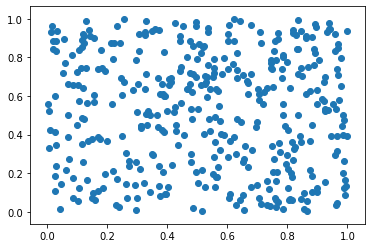

In [3]:
# Initial particle positions: Random uniform distribution

positions = np.random.uniform(0.0, 1.0, size=(n_particles, 2))

plt.scatter(positions[:,0], positions[:,1])
plt.show()

# ->> One potential issue with this is that particles may end up on top of
#     each other, which may cause numerical instabilities depending on the
#     time step functions used to simulate the system.

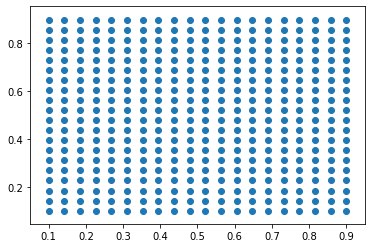

In [4]:
# Initial particle positions: Alternative with a regular grid

positions = np.meshgrid(np.linspace(0.1, 0.9, int(np.sqrt(n_particles))),
                        np.linspace(0.1, 0.9, int(np.sqrt(n_particles))))
positions = np.array([positions[0].flatten(), positions[1].flatten()]).T

plt.scatter(positions[:,0], positions[:,1])
plt.show()

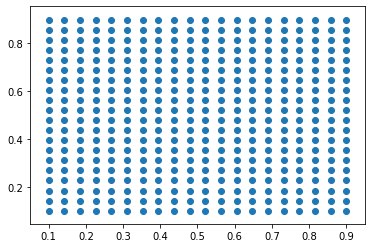

In [5]:
# Initial particle positions: Regular grid but ensuring a different number of particles is handled correctly

positions = np.meshgrid(np.linspace(0.1, 0.9, int(np.ceil(np.sqrt(n_particles)))),
                        np.linspace(0.1, 0.9, int(np.ceil(np.sqrt(n_particles)))))
positions = np.array([positions[0].flatten(), positions[1].flatten()]).T
positions = positions[:n_particles]

plt.scatter(positions[:,0], positions[:,1])
plt.show()

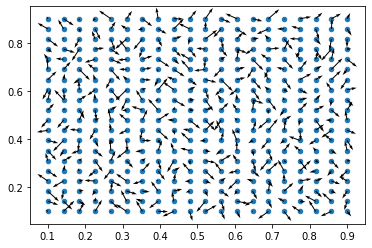

In [6]:
# Initial velocities: random uniform distribution
# Note: This is NOT what you would expect from an ideal gas at equilibrium, see below!

velocities = np.random.uniform(-0.1, 0.1, size=(n_particles, 2))

plt.scatter(positions[:,0], positions[:,1], s=20)
plt.quiver(positions[:,0], positions[:,1], velocities[:,0], velocities[:,1]) # (See note below!)
plt.show()

# Note that the quiver function has some peculiarities in terms of how it determines
# the angles of the vectors shown. Carefully read the docstring when using it and make
# sure you test it on a simple/clear example, especially when you need to rescale the
# arrows in some fashion!

#### First step function: simple particle motion

First, we implement just the simple ballistic particle motion. Particles do not interact yet.

In [7]:
def motion_step(positions, velocities, delta_t):
    return positions + velocities * delta_t

In [8]:
# Container for saving what happens over the course of the simulation 
all_positions = np.zeros((n_steps+1, n_particles, 2))
all_positions[0] = positions  # Initial time point

# Running the simulation
for s in range(n_steps):
    all_positions[s+1] = motion_step(all_positions[s], velocities, delta_t)    

In [9]:
# Interactive visualization
from ipywidgets import interact

@interact(t=(0,n_steps,1))
def show_it(t=0):
    plt.figure(figsize=(7,7))
    plt.scatter(all_positions[t,:,0], all_positions[t,:,1], s=10)
    #plt.quiver(all_positions[t,:,0], all_positions[t,:,1], velocities[:,0], velocities[:,1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()

# ->> The particles all move ballistically in their initial direction and disperse.

interactive(children=(IntSlider(value=0, description='t', max=200), Output()), _dom_classes=('widget-interact'…

#### Adding elastic particle collision

In [10]:
# Step 1: detecting collisions

import scipy.spatial.distance as dist
def collision_detection(positions, collision_range=0.01):
    distances  = dist.squareform(dist.pdist(positions, ))
    collisions = distances < collision_range
    #plt.imshow(collisions, interpolation='none')
    return collisions

In [11]:
# Step 2: updating the velocity of two colliding particles

def collision_equation(x1, x2, v1, v2):
    """See here: https://en.wikipedia.org/wiki/Elastic_collision"""
    return v1 - (np.dot(v1-v2, x1-x2) / np.linalg.norm(x1-x2)**2.0) * (x1-x2)

In [12]:
# Putting it together

def resolve_collisions(positions, velocities):
    
    # Find collided particles
    collisions = collision_detection(positions)
    collision_indices = np.where(np.triu(collisions, k=1))
    
    # Update velocities for each collision pair
    for p1, p2 in zip(*collision_indices):
        v_p1 = collision_equation(positions[p1], positions[p2],
                                  velocities[p1], velocities[p2])
        v_p2 = collision_equation(positions[p2], positions[p1],
                                  velocities[p2], velocities[p1])
        velocities[p1] = v_p1
        velocities[p2] = v_p2
    
    return velocities

# Notes:
#   1) This is a very simple implementation and there are edge cases it
#      does not handle correctly, for instance when three particles 
#      collide within the same time step. This leads to numerical errors,
#      as we will see later on. There are many options for fixing this
#      but I couldn't think of a particularly elegant one, so this is 
#      left unadressed for now.
#   2) The loop could potentially be vectorized completely, provided the
#      collision_equation function can be vectorized. This is a little 
#      bit tricky because the dot/inner product functions don't allow
#      axis-wise application over a dimension of an array, so another
#      approach (e.g. based on `np.tensordot`) would be needed.

In [13]:
# A little addition to prevent our particles from just dispersing into space

# Continuous boundaries (aka periodic boundaries) essentially "wrap around",
# so that a particle leaving the specified space on one side will re-enter
# it from the other. This is a very common trick in numerical simulation, as
# it doesn't require special rules to be implemented for collisions with a
# "hard" outer boundary. A simple alternative would be to place immobile 
# particles along the boundary; bouncing off of these could be simulated in
# much the same way as collisions between particles.
# Note that this implementation is not perfect. Although it nicely relocates
# particles, the continuity of the boundaries is not considered during the
# detection of collisions above!

def continuous_boundaries(pos, minbd=0.0, maxbd=1.0):
    # Note the great use of the modulo here; thanks to Gregor Moenke for this suggestion!
    return (pos + minbd) % maxbd

In [14]:
# Run the simulation

all_positions = np.zeros((n_steps+1, n_particles, 2))
all_velocities = np.zeros((n_steps+1, n_particles, 2))  # Now we also keep track of vlocities

all_positions[0] = positions
all_velocities[0] = velocities

for s in range(n_steps):
    all_positions[s+1] = motion_step(all_positions[s], all_velocities[s], delta_t)  # Ballistic motion
    all_positions[s+1] = continuous_boundaries(all_positions[s+1])  # Periodic boundary
    all_velocities[s+1] = resolve_collisions(all_positions[s+1], all_velocities[s])  # Resolution of collisions

In [15]:
@interact(t=(0,n_steps,1))
def show_it(t=0):
    plt.figure(figsize=(7,7))
    plt.scatter(all_positions[t,:,0], all_positions[t,:,1], s=10)
    plt.quiver(all_positions[t,:,0], all_positions[t,:,1], all_velocities[t,:,0], all_velocities[t,:,1])
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=200), Output()), _dom_classes=('widget-interact'…

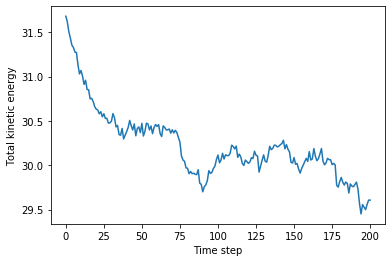

In [16]:
# Validation: total kinetic energy over time
plt.plot(np.sum(np.sqrt(np.sum(all_velocities**2.0, axis=-1)), axis=(1)))
plt.ylabel("Total kinetic energy")
plt.xlabel("Time step")
plt.show()

# ->> We would expect this to remain constant because of conservation
#     of momentum - and it almost does; the changes are very minor.
#     The residual energy loss is likely a numerical error resulting
#     from the problems with triple collisions noted above.
#     

In [17]:
# Validation: frequency distribution of speeds

# As mentioned above, an ideal gas like ours is not expected to have a uniformly
# random distribution of particle speeds. The expected distribution is instead
# given by the Maxwell-Boltzmann distribution and is related to the absolute
# temperature of the gas.
# See en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution

# Theoretical prediction
from scipy.constants import Boltzmann as k_B
def MW_BW(s_vec, s_data, ds, m=1.0):
    
    # Mean kinetic energy
    E_m = np.mean(1/2 * m * s_data**2)
    
    # Temperature in Kelvin
    T_K = 2/3 * E_m/k_B    
    
    # Maxwell-Boltzmann distribution
    mw_bw = (m*s_vec) / (k_B*T_K) * np.exp(-(m*s_vec**2)/(2*k_B*T_K)) * ds
    
    return mw_bw

# Theory vs reality
@interact(t=(0,n_steps,1))
def show_it(t=0):
    
    v_data = all_velocities[t]
    s_data = np.linalg.norm(v_data, axis=1)
    
    weights = np.ones_like(s_data) / s_data.size
    plt.hist(s_data, bins=50, weights=weights)
    
    s = np.linspace(0, 0.2, 50)
    plt.plot(s, MW_BW(s, s_data, s[1]))
    
    plt.ylim([0, 0.07])
    plt.ylabel("Frequency")
    plt.xlabel("Speed")
    plt.show()
    
# ->> We can see that our particles relax toward the predicted 
#     distribution with time, which is a very good sign. To be
#     fully convinced that the model works correctly, multiple
#     simulations would have to be run, each with a different
#     random sample of initial particle velocities. This would
#     allow for a statistical comparison of simulations vs the
#     Maxwell-Boltzmann prediction.

interactive(children=(IntSlider(value=0, description='t', max=200), Output()), _dom_classes=('widget-interact'…

### If Particles Were People

A quick and simple example to showcase that particle models can be adopted to many use cases - in this case epidemiological modeling.

We simply start tracking an additional property associated with each particle, i.e. "infected" vs. "non-infected" and we write a corresponding propagator that roughly says "whenever an infected particle collides with a non-infected particle, the non-infected particle becomes infected".

Note that whilst this nicely recapitulates exponential growth and whilst similar models are indeed used in epidemiology (see [here](https://www.youtube.com/watch?v=gxAaO2rsdIs) for a great video on the topic), the model shown here is **not suitable** for real applications. Its limitations are manifold, including:
- People don't bounce around as ballistic particles with elastic collisions; they move on social networks and the properties of their movement can change (e.g. due to quarantine). 
- People aren't simply "infected" or "non-infected"; the most common states used in actual epidemiology are "Susceptible", "Infected" and "Removed" ([SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)), though there are also many further extension to this. 
- Predictions about real epidemics need to be fit to data, which is done with more abstract mathematical models that do not require simulation of individual particles.

In [18]:
# A new particle property: infected (True) or non-infected (False)

all_infected = np.zeros((n_steps+1, n_particles), dtype=np.bool)
all_infected[0,0] = True  # We start with a single infected individual

In [19]:
# The time step function for the new property: collisions lead to infections

def infect_collided(positions, infected):
    
    # Find collisions
    collisions = collision_detection(positions)
    collision_indices = np.where(np.triu(collisions, k=1))
    
    # Infect participants
    for p1,p2 in zip(*collision_indices):
        if infected[p1] or infected[p2]:
            infected[p1] = True
            infected[p2] = True
    
    return infected

# Note that it would be vastly more efficient to integrate this with the
# `resolve_collisions` function above, as collisions then only need to
# be detected once. Doing so would however make the `resolve_collisions`
# function more complicated. In general, it is important to refactor code
# as more and more properties and propagators are added to a model, so as
# to keep it readily maintainable and extensible!

In [20]:
# Run the simulation

all_positions = np.zeros((n_steps+1, n_particles, 2))
all_velocities = np.zeros((n_steps+1, n_particles, 2))

all_positions[0] = positions
all_velocities[0] = velocities

for s in range(n_steps):
    all_positions[s+1] = motion_step(all_positions[s], all_velocities[s], delta_t) 
    all_positions[s+1] = continuous_boundaries(all_positions[s+1])
    all_velocities[s+1] = resolve_collisions(all_positions[s+1], all_velocities[s])
    all_infected[s+1] = infect_collided(all_positions[s+1], all_infected[s])

In [21]:
@interact(t=(0,n_steps,1))
def show_it(t=0):
    plt.figure(figsize=(8,8))
    plt.scatter(all_positions[t,:,0], all_positions[t,:,1],
                c=all_infected[t], cmap='coolwarm', vmin=0, vmax=1)
    plt.axis('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=200), Output()), _dom_classes=('widget-interact'…

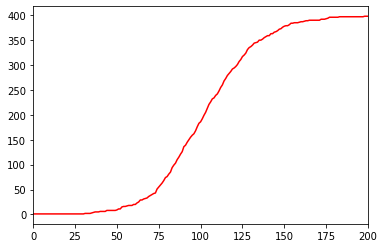

In [22]:
plt.plot(np.sum(all_infected, axis=1), c='r')
plt.xlim([0, 200])
plt.show()

# ->> There we go: exponential growth!

### If Particles Were Cells

One area of biology where particle models are very useful is the simulation of tissue-scale dynamics in cases where single cells can be abstracted to simple particles. Implementing this is a little too tricky but here is an example simulation based on an old model I coded a while ago:

<video width="640" height="480" src="data/cell_sorting.webm" type="video/webm" controls></video>

The model makes the following assumptions:

- Ballistic motion (conservation of momentum) is removed, as cells generally do not move ballistically
- The update of cell positions at each step is thus directly based on a sum of the forces a cell experiences
- These forces are exerted by neighboring cells. There are two main components:
    - An attractive force that decreases with distance; it simulates cell-cell adhesion
    - A repulsive force that exponentially increases as the distance to a neighbor gets smaller; it simulates incompressibilty
    
   
An explanation of this particular video:
    
- In this specific run of the model, blue cells have a higher attractive force to other blue cells and red cells have a higher attractive force to other red cells.
- As you can see, this simple bias is sufficient to induce cell sorting and thus drive the emergence of a spatial pattern, despite the initially random positions. Note that this model generally leads to only two groups; the four groups emerging here are a peculiarity of this particular initial cell distribution. In other words, this particular outcome is a local minimum in the system's energy landscape rather than the global minimum.
- This kind of sorting-based pattern generation is known as the Differential Adhesion Hypothesis (DAH) or - more generally - the Differential Interfacial Tension Hypothesis (DITH). It is thought to be involved in many biological systems in embryonic development.


In recent years, sophisticated frameworks for this kind of particule-based cell modeling have been written. A great example is ya||a ([paper](https://www.sciencedirect.com/science/article/pii/S2405471219300687), [github](https://github.com/germannp/yalla)) from the Sharpe lab at EMBL Barcelona, which boasts features such as full 3D modeling, GPU acceleration, and many pre-cooked properties and propagators to model e.g. cell migration, cell polarity, cell division, and so on. Unfortunately, it is written in CUDA and does not currently provide an intuitive python API. ;)